<a href="https://colab.research.google.com/github/kode-git/ViT-FER/blob/main/ViT_Face_Emotion_Recognition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Notebook: ViT Face Emotion Recognition


## 1. Introduction


ViT Face Emotion Recognition is a project based on the use of transformers for image classification. Our project demonstrated that transformers could classify some images in tasks like emotion recognition. The project has three different datasets in input that must merge into one homogeneous dataset. Firstly, we need to resize images using a 224x224 total dimension because transformers have the same linear size for the input and the patching phase needs the same amount of data. The result subsets must merge on one dataset called ViT. 

ViT Dataset has eight different classes integrated by three different subsets:
1. FER-2013: Fer2013 contains approximately 30,000 facial RGB images of different expressions with a size restricted to 48×48, and the main labels can be split into seven types: 0=Angry, 1=Disgust, 2=Fear, 3=Happy, 4=Sad, 5=Surprise, 6=Neutral. The Disgust expression has a minimal number of images – 600, while other labels have nearly 5,000 samples each.
2. CK+: The Extended Cohn-Kanade (CK+) dataset contains images extrapolated from 593 video sequences from 123 different subjects, ranging from 18 to 50 years of age with a variety of genders and heritage. Each video shows a facial shift from the neutral expression to a targeted peak expression, recorded at 30 frames per second (FPS) with a resolution of either 640x490 or 640x480 pixels. Unfortunately, we do not have all generated datasets, but we stored only 1000 images with high variance from a Kaggle repository. 
3. AffectNet: It is a sizeable facial expression dataset with 40k images classified in eight categories (neutral, happy, angry, sad, fear, surprise, disgust, contempt) of facial expressions along with the intensity of valence and arousal.

Each dataset focuses on RGB channels for the colouring and has different sizes and image extensions entirely stored in Google Drive (the total amount of data is around 2 GB). So, we need to establish a standard format to manage them simultaneously. Finally, we will pass in a data augmentation phase to improve the total amount of images to balance the number of samples for each category. 

Finally, we have the final sections interested in the fine-tuning phase and training on a few models that can be saved locally on the drive and used in an external application for real-time classification on an ad-hoc application. More information about modelling is in the following sections.

## 2. Data Retrieval

### 2.1 Import Libraries and Utility class

In [1]:
!pip3 install Pillow
!pip install pandas

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
import seaborn as sns
import os, cv2, glob, imageio, random

In [3]:
from PIL import Image

Data sources about datasets described in the previous section are in Google Drive, so we need to manage files in a shared directory and integrate them into a single unit by merging images of the same classes from different datasets.

Loading data from the Google Drive

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


The following snippet of code describes essential functions used for the integration; ImageWorker is a class that we can use to convert the size format of an image (to make them in a standard dimension), change the extension of an image and can evaluate the number of images per class in each of exciting datasets.

In [5]:
class ImageWorker():


    def __init__(self) -> None:
         pass


    def format_converter(self, path, format_img, source_type, dest_path):
        count = 0
        for file in glob.glob(path + "/*." + format_img):
            img = cv2.imread(file, cv2.IMREAD_UNCHANGED)
            resized = cv2.resize(img, (224,224), interpolation=cv2.INTER_CUBIC)
            print('Resized writing for', dest_path + "resized_on_" + source_type + "_" + str(count) + "." + format_img )
            cv2.imwrite(dest_path + "resized_on_" + source_type + "_" + str(count) + "."+ format_img, resized)
            count += 1



    def list_classes(self, dataset_path):
        langs = []
        for el in glob.glob(dataset_path):
          langs.append(os.path.basename(str(el)))
        return langs



    def counter_samples_on_class(self, dataset_path):
      classes = self.list_classes(dataset_path)
      counter_classes = {}
      if dataset_path[len(dataset_path) - 1] == "/":
          path = dataset_path
      if dataset_path[len(dataset_path) - 1] == "*":
          path = dataset_path[0:len(dataset_path) - 2] + "/"
      else:
          path = dataset_path + "/"
      for class_ in classes:
        counter = 0
        for file in glob.glob(path + class_ + "/*"):
            counter += 1
        counter_classes[class_] = counter
      return counter_classes



    def counter_samples(self, dataset_path):
     a = self.counter_samples_on_class(dataset_path)
     counter = 0
     for el in a.keys():
       counter += a[el]
     return counter



    def extension_converter(self, path, format_source, format_result, dest_path):   
      for file in glob.glob(path + "/*." + format_source):
          im1 = Image.open(file)
          im1.save(file[0:len(file)-4] + "." + format_result)
          os.remove(file)



    def counter_file_extension(self, path, format):
      counter = 0
      for file in glob.glob(path + "/*." + format):
          counter += 1
      return counter
      

      
    def navigate_path(self, path):    
        count = 0
        for dir in os.listdir(path):
            if os.path.isfile(os.path.join(path, dir)):
                count += 1
        return count

iw = ImageWorker()

In [6]:
# Other utility functions related to properties of images

def mean(values):
  if len(values) <= 0:
    return 0
  else:
    sum = 0
    for el in values:
      sum += el
    return int(sum / len(values))



def min(val):
  min = sys.maxsize
  for el in val.keys():
    if val[el] < min:
      min = val[el]
  return min


def max(val):
  max = sys.minsize
  for el in val.keys():
    if val[el] > max:
      max = val[el]
  return max


def plot_dataset(dataset_path, title=""):
  classes = iw.list_classes(dataset_path)
  l_classes = iw.counter_samples_on_class(dataset_path)

  fig = plt.figure()
  ax = fig.add_axes([0,0,1,1,])
  x = [l_classes[class_] for class_ in classes]
  y = [class_ for class_ in classes]
  
  colors = []
  x_cap = mean(x)

  # colors identify when the elements are greater or lesser than the mean values
  for el in x:
    if el < x_cap:
      colors.append("#BC3434")
    else:
      colors.append("#49A131")
  ax.bar(y, x, color=colors)
  plt.title(title)
  plt.show()



def channels_distribution(dataset_path):
  chan_size = [0 for i in range(0, 5)]
  for path in glob.glob(dataset_path):
    for el in os.listdir(path):
       pic = imageio.imread(path + "/" + el)
       chan_size[pic.ndim] += 1
  return chan_size


In [ ]:
!mkdir /content/drive/MyDrive/Datasets/AVFER/
!mkdir /content/drive/MyDrive/Datasets/AVFER/train
!mkdir /content/drive/MyDrive/Datasets/AVFER/val
!mkdir /content/drive/MyDrive/Datasets/AVFER/test

In [ ]:
base_dir = "/content/drive/MyDrive/Datasets/AVFER/"
x = "/content/drive/MyDrive/Datasets/AffectNet/train_class/"
subfolders = [el for el in os.listdir(base_dir)]
classes = [cl for cl in os.listdir(x)]


for cl in classes:
  for folder in subfolders:
    os.mkdir(base_dir  + folder + "/" + cl)

### 2.2 FER2013 Dataset
FER2013 is a dataset composed of 35.000 images in 7 classes (fear, disgust, sad, happy, neutral, surprise, angry). Images are in size 48x48 with a grey-scaled colours palette. The classes' variations and features distributions are helpful in the merging phase for other classes to obtain a good distribution and normalize the amount of data variation. According to the final classification, the contempt class was missed on this kind of dataset.

In [ ]:
num_classes = 7

data_train_fer = '/content/drive/My Drive/Datasets/FER-2013/train/*'
data_val_fer = '/content/drive/My Drive/Datasets/FER-2013/val/*'

fer_classes_t = iw.list_classes(data_train_fer)
fer_classes_v = iw.list_classes(data_val_fer)

In [ ]:
fer_classes_t

In [ ]:
fer_classes_v

In [ ]:
fer_train_tot = iw.counter_samples(data_train_fer)
fer_val_tot = iw.counter_samples(data_val_fer)
fer_tot = fer_train_tot + fer_val_tot
print("Total no. of images in FER: ", fer_tot)
print("Total no. of train images in FER:", fer_train_tot)
print("Total no. of val images in FER:", fer_val_tot)

In [ ]:
plot_dataset(data_train_fer)

In [ ]:
plot_dataset(data_val_fer)

FER2013 do not have many samples for the disgust class. This observation guarantees an excellent motivation to merge it with other datasets and the data augmentation phase. Furthermore, it is unbalanced, and we need to manage it in data augmentation or data integration with some samples from other datasets to make a result set with the same number of samples for each class.

In [ ]:
paths = []
for path in glob.glob("/content/drive/MyDrive/Datasets/FER-2013/train/*"):
  paths.append(path + "/*.jpg")

results = []
for path in paths:
  counter = 0
  for file in glob.glob(path):
    if counter < 10:
      results.append(cv2.imread(file))
      counter += 1
    else: 
      break

print(len(results))
for j in range(0, num_classes):
  fig, ax = plt.subplots(nrows=1, ncols=10, figsize=(15,15))
  for i in range(0,10):
    ax[i].imshow(cv2.cvtColor(results[i+j*10], cv2.COLOR_BGR2RGB))
    ax[i].axis('off')


This dataset is pretty good in terms of data views, with some variance in the patterns given by a significant variability of facial expressions for each category. The image size is 48x48; we need to resize it to 224x224 size and put it together in the same folder as the other datasets for data integration. We will use our ImageWorker object to do that.

In [ ]:
sample_img = '/content/drive/MyDrive/Datasets/FER-2013/val/anger/PrivateTest_10131363.jpg'
pic = imageio.imread(sample_img)
plt.figure(figsize = (5,5))
plt.imshow(pic)

In [ ]:
print('Type of the image : ' , type(pic)) 
print('Shape of the image : {}'.format(pic.shape)) 
print('Dimension of Image: {}'.format(pic.ndim))
print('Image size: {}'.format(pic.size)) 
print('Maximum channel value in this image: {}'.format(pic.max())) 
print('Minimum channel value in this image: {}'.format(pic.min()))

We need to check if there are any images in the dataset with different shapes and color dimensions.

In [ ]:
train_ch = channels_distribution(data_train_fer)
val_ch = channels_distribution(data_val_fer)

if len(train_ch) == len(val_ch):
  tot_ch = [0 for i in range(len(train_ch))]
  for i in range(0, len(train_ch)):
     tot_ch[i] = train_ch[i] + val_ch[i]

print('Total channels distribution :', tot_ch)

Given expected output, we can merge training and validation subfolders in the final dataset with a regular size of 224 x 224

In [ ]:
# Resize FER-2013 training images in 224x224 and put the result in the final dataset

format_fer = "jpg"
source_type = "fer_2013"

destinations = ["/content/drive/MyDrive/Datasets/AVFER/train/" + class_ + "/" for class_ in fer_classes_t]
sources = ["/content/drive/MyDrive/Datasets/FER-2013/train/" + class_ for class_ in fer_classes_t]

for i in range(0,len(destinations)):
  iw.format_converter(sources[i], format_fer, source_type, destinations[i])

Streaming output truncated to the last 5000 lines.
Resized writing for /content/drive/MyDrive/Datasets/AVFER/train/neutral/resized_on_fer_2013_3970.jpg
Resized writing for /content/drive/MyDrive/Datasets/AVFER/train/neutral/resized_on_fer_2013_3971.jpg
Resized writing for /content/drive/MyDrive/Datasets/AVFER/train/neutral/resized_on_fer_2013_3972.jpg
Resized writing for /content/drive/MyDrive/Datasets/AVFER/train/neutral/resized_on_fer_2013_3973.jpg
Resized writing for /content/drive/MyDrive/Datasets/AVFER/train/neutral/resized_on_fer_2013_3974.jpg
Resized writing for /content/drive/MyDrive/Datasets/AVFER/train/neutral/resized_on_fer_2013_3975.jpg
Resized writing for /content/drive/MyDrive/Datasets/AVFER/train/neutral/resized_on_fer_2013_3976.jpg
Resized writing for /content/drive/MyDrive/Datasets/AVFER/train/neutral/resized_on_fer_2013_3977.jpg
Resized writing for /content/drive/MyDrive/Datasets/AVFER/train/neutral/resized_on_fer_2013_3978.jpg
Resized writing for /content/drive/MyDri

The data integration phase did not distinguish between train and test splitting. So, we can merge the FER-2013 val set with the training set and split it a second time. Our interest is to analyze the val set as well as we did with the training set.

In [ ]:
# Resize FER-2013 validation images in 224x224 and put the result in the final dataset

sources = ["/content/drive/MyDrive/Datasets/FER-2013/val/" + class_ + "/" for class_ in fer_classes_t]
source_type = "fer_2013_test"

for i in range(0, len(destinations)):
  iw.format_converter(sources[i], format_fer, source_type, destinations[i])

Streaming output truncated to the last 5000 lines.
Resized writing for /content/drive/MyDrive/Datasets/AVFER/train/fear/resized_on_fer_2013_test_404.jpg
Resized writing for /content/drive/MyDrive/Datasets/AVFER/train/fear/resized_on_fer_2013_test_405.jpg
Resized writing for /content/drive/MyDrive/Datasets/AVFER/train/fear/resized_on_fer_2013_test_406.jpg
Resized writing for /content/drive/MyDrive/Datasets/AVFER/train/fear/resized_on_fer_2013_test_407.jpg
Resized writing for /content/drive/MyDrive/Datasets/AVFER/train/fear/resized_on_fer_2013_test_408.jpg
Resized writing for /content/drive/MyDrive/Datasets/AVFER/train/fear/resized_on_fer_2013_test_409.jpg
Resized writing for /content/drive/MyDrive/Datasets/AVFER/train/fear/resized_on_fer_2013_test_410.jpg
Resized writing for /content/drive/MyDrive/Datasets/AVFER/train/fear/resized_on_fer_2013_test_411.jpg
Resized writing for /content/drive/MyDrive/Datasets/AVFER/train/fear/resized_on_fer_2013_test_412.jpg
Resized writing for /content/dr

### 2.3  CK+ Dataset
It is a small dataset composed of 981 images in seven classes (fear, disgust, sad, happy, neutral, surprise, angry). Images are in size 48x48 with a grey-scaled colours palette. The classes' variations and features distributions are helpful in the merging phase for other classes to obtain a good distribution and normalize the amount of data variation. 

In [ ]:
num_classes = 7

data_dir_ck = '/content/drive/My Drive/Datasets/CK+48/*'
ck_classes_t = iw.list_classes(data_dir_ck)
ck_classes_t

['fear', 'sadness', 'happy', 'anger', 'disgust', 'contempt', 'surprise']

In [ ]:
ck_tot = iw.counter_samples(data_dir_ck)
print("Total no. of images in CK+: ", ck_tot)

In [ ]:
plot_dataset("/content/drive/MyDrive/Datasets/CK+48/*")

In [ ]:
paths = []
for path in glob.glob(data_dir_ck):
  paths.append(path + "/*.png")

results = []
num_classes = len(ck_classes_t)
print(num_classes)
for path in paths:
  counter = 0
  for file in glob.glob(path):
    if counter < 10:
      results.append(cv2.imread(file))
      counter += 1
    else: 
      break

print(len(results))
for j in range(0, num_classes):
  fig, ax = plt.subplots(nrows=1, ncols=10, figsize=(15,15))
  for i in range(0,10):
    ax[i].imshow(cv2.cvtColor(results[i+j*10], cv2.COLOR_BGR2RGB))
    ax[i].axis('off')

The image size is 48x48. To retrieve some data in a standard format, we will try to resize them, maintaining pixels patterns for data processing. The new size is 224x224, which should maintain in a good way features of the samples. We will save the resized images in a new folder on the drive.

In [ ]:
sample_img = '/content/drive/MyDrive/Datasets/CK+48/anger/Copia di S010_004_00000017.png'
pic = imageio.imread(sample_img)
plt.figure(figsize = (5,5))
plt.imshow(pic)

In [ ]:
print('Type of the image : ' , type(pic)) 
print('Shape of the image : {}'.format(pic.shape)) 
print('Dimension of Image: {}'.format(pic.ndim))
print('Image size: {}'.format(pic.size)) 
print('Maximum channel value in this image: {}'.format(pic.max())) 
print('Minimum channel value in this image: {}'.format(pic.min()))

In [ ]:
print('Total channels distribution :', channels_distribution(data_dir_ck))

In [ ]:
# Resize images and put the result in the final dataset

format_ck = "png"
source_type = "ck_plus"

destinations = ["/content/drive/MyDrive/Datasets/AVFER/train/" + class_ + "/" for class_ in ck_classes_t]
sources = ["/content/drive/MyDrive/Datasets/CK+48/" + class_ for class_ in ck_classes_t]

for i in range(0,len(destinations)):
  iw.format_converter(sources[i], format_ck, source_type, destinations[i])

Resized writing for /content/drive/MyDrive/Datasets/AVFER/train/fear/resized_on_ck_plus_0.png
Resized writing for /content/drive/MyDrive/Datasets/AVFER/train/fear/resized_on_ck_plus_1.png
Resized writing for /content/drive/MyDrive/Datasets/AVFER/train/fear/resized_on_ck_plus_2.png
Resized writing for /content/drive/MyDrive/Datasets/AVFER/train/fear/resized_on_ck_plus_3.png
Resized writing for /content/drive/MyDrive/Datasets/AVFER/train/fear/resized_on_ck_plus_4.png
Resized writing for /content/drive/MyDrive/Datasets/AVFER/train/fear/resized_on_ck_plus_5.png
Resized writing for /content/drive/MyDrive/Datasets/AVFER/train/fear/resized_on_ck_plus_6.png
Resized writing for /content/drive/MyDrive/Datasets/AVFER/train/fear/resized_on_ck_plus_7.png
Resized writing for /content/drive/MyDrive/Datasets/AVFER/train/fear/resized_on_ck_plus_8.png
Resized writing for /content/drive/MyDrive/Datasets/AVFER/train/fear/resized_on_ck_plus_9.png
Resized writing for /content/drive/MyDrive/Datasets/AVFER/tr

### 2.4 AffectNet Dataset
AffectNet dataset has samples of different sizes, high-quality images in grey-scale or coloured in RGB range. It has eight different classes (surprise, angry, sad, contempt, disgust, fear, neutral, and happy). As the FER-2013, there is a division between testing and training set; we will merge it as well as we did with FER subsets. Furthermore, we resize the different sizes of its images in 224x224 to establish the same amount of pixels for each sample.

In [ ]:
num_classes = 8

data_train_af = '/content/drive/My Drive/Datasets/AffectNet/train_class/*'
data_val_af = '/content/drive/My Drive/Datasets/AffectNet/val_class/*'

af_classes_t = iw.list_classes(data_train_af)
af_classes_v = iw.list_classes(data_val_af)

In [ ]:
af_classes_t

In [ ]:
af_classes_v

In [ ]:
af_train_tot = iw.counter_samples(data_train_af)
af_val_tot = iw.counter_samples(data_val_af)
af_tot = af_train_tot + af_val_tot
print("Total no. of images in AffectNet: ", af_tot)
print("Total no. of train images in AffectNet:", af_train_tot)
print("Total no. of val images in AffectNet:", af_val_tot)

In [ ]:
plot_dataset(data_train_af)

In [ ]:
plot_dataset("/content/drive/MyDrive/Datasets/AffectNet/val_class/*")

In [ ]:
paths = []
for path in glob.glob(data_train_af):
  paths.append(path + "/*.jpg")

results = []
num_classes = len(af_classes_t)
print(num_classes)
for path in paths:
  counter = 0
  for file in glob.glob(path):
    if counter < 10:
      results.append(cv2.imread(file))
      counter += 1
    else: 
      break

print(len(results))
for j in range(0, num_classes):
  fig, ax = plt.subplots(nrows=1, ncols=10, figsize=(15,15))
  for i in range(0,10):
    ax[i].imshow(cv2.cvtColor(results[i+j*10], cv2.COLOR_BGR2RGB))
    ax[i].axis('off')

In [ ]:
sample_affectnet = '/content/drive/MyDrive/Datasets/AffectNet/train_class/anger/Copia di image0000006.jpg'
pic = imageio.imread(sample_affectnet)
plt.figure(figsize = (5,5))
plt.imshow(pic)

In [ ]:
print('Type of the image : ' , type(pic)) 
print('Shape of the image : {}'.format(pic.shape)) 
print('Image Hight {}'.format(pic.shape[0])) 
print('Image Width {}'.format(pic.shape[1])) 
print('Dimension of Image {}'.format(pic.ndim))

In [ ]:
print('Image size {}'.format(pic.size)) 
print('Maximum RGB value in this image {}'.format(pic.max())) 
print('Minimum RGB value in this image {}'.format(pic.min()))

Check values of a center pixel of the image, we will obtains values related to each RGB channels

In [ ]:
print('Value of only R channel {}'.format(pic[387, 387, 0])) 
print('Value of only G channel {}'.format(pic[387, 387, 1])) 
print('Value of only B channel {}'.format(pic[387, 387, 2]))

Generally, we can visualize the matrix of pixel in the 3 different channels values in the whole image.

In [ ]:
fig, ax = plt.subplots(nrows = 1, ncols=3, figsize=(15,5))  
for c, ax in zip(range(3), ax):     
    ax.imshow(pic[ :, :, c])

Now, we know that each pixel of the image is represented by three integers. Splitting the image into separate color components is just a matter of pulling out the correct slice of the image array. So, we can use the zero matrix generated by the original version given by the zero function from numpy library.

In [ ]:
pic = imageio.imread(sample_affectnet) 
fig, ax = plt.subplots(nrows = 1, ncols=3, figsize=(15,5))  
for c, ax in zip(range(3), ax):         
     split_img = np.zeros(pic.shape, dtype="uint8") # make a zero matrix
     split_img[ :, :, c] = pic[ :, :, c] # visualize one of the 3 channel
     ax.imshow(split_img)

In [ ]:
# checking possible sizes of the matrix of pixels 



In [ ]:
train_ch = channels_distribution(data_train_af)
val_ch = channels_distribution(data_val_af)

if len(train_ch) == len(val_ch):
  tot_ch = [0 for i in range(len(train_ch))]
  for i in range(0, len(train_ch)):
     tot_ch[i] = train_ch[i] + val_ch[i]

print('Total channels distribution :', tot_ch)

In [ ]:
# Format of the image in the AffectNet
format_affectnet = "jpg"
source_type = "affect_net"

# We pass the AffectNet dataset in the validation set to balance it in the validation and testing subset
# Given a size bigger than CK+48 and FER-2013, we can use only a part in training and mantains the 
# rest in the testing and validation (only a small part related to the training set)
destinations = ["/content/drive/MyDrive/Datasets/AVFER/val/" + class_ + "/" for class_ in af_classes_t]
sources = ["/content/drive/MyDrive/Datasets/AffectNet/train_class/" + class_ + "/" for class_ in af_classes_t]


for i in range(0,len(destinations)):
  iw.format_converter(sources[i], format_affectnet, source_type, destinations[i])

Streaming output truncated to the last 5000 lines.
Resized writing for /content/drive/MyDrive/Datasets/AVFER/val/sad/resized_on_affect_net_0.jpg
Resized writing for /content/drive/MyDrive/Datasets/AVFER/val/sad/resized_on_affect_net_1.jpg
Resized writing for /content/drive/MyDrive/Datasets/AVFER/val/sad/resized_on_affect_net_2.jpg
Resized writing for /content/drive/MyDrive/Datasets/AVFER/val/sad/resized_on_affect_net_3.jpg
Resized writing for /content/drive/MyDrive/Datasets/AVFER/val/sad/resized_on_affect_net_4.jpg
Resized writing for /content/drive/MyDrive/Datasets/AVFER/val/sad/resized_on_affect_net_5.jpg
Resized writing for /content/drive/MyDrive/Datasets/AVFER/val/sad/resized_on_affect_net_6.jpg
Resized writing for /content/drive/MyDrive/Datasets/AVFER/val/sad/resized_on_affect_net_7.jpg
Resized writing for /content/drive/MyDrive/Datasets/AVFER/val/sad/resized_on_affect_net_8.jpg
Resized writing for /content/drive/MyDrive/Datasets/AVFER/val/sad/resized_on_affect_net_9.jpg
Resized w

In [ ]:
source_type = "affectnet_2"

destinations = ["/content/drive/MyDrive/Datasets/AVFER/test/" + class_ + "/" for class_ in af_classes_t]
sources = ["/content/drive/MyDrive/Datasets/AffectNet/val_class/" + class_ for class_ in af_classes_t]

for i in range(0,len(destinations)):
  iw.format_converter(sources[i], format_affectnet, source_type, destinations[i])


Resized writing for /content/drive/MyDrive/Datasets/AVFER/test/happy/resized_on_affectnet_2_0.jpg
Resized writing for /content/drive/MyDrive/Datasets/AVFER/test/happy/resized_on_affectnet_2_1.jpg
Resized writing for /content/drive/MyDrive/Datasets/AVFER/test/happy/resized_on_affectnet_2_2.jpg
Resized writing for /content/drive/MyDrive/Datasets/AVFER/test/happy/resized_on_affectnet_2_3.jpg
Resized writing for /content/drive/MyDrive/Datasets/AVFER/test/happy/resized_on_affectnet_2_4.jpg
Resized writing for /content/drive/MyDrive/Datasets/AVFER/test/happy/resized_on_affectnet_2_5.jpg
Resized writing for /content/drive/MyDrive/Datasets/AVFER/test/happy/resized_on_affectnet_2_6.jpg
Resized writing for /content/drive/MyDrive/Datasets/AVFER/test/happy/resized_on_affectnet_2_7.jpg
Resized writing for /content/drive/MyDrive/Datasets/AVFER/test/happy/resized_on_affectnet_2_8.jpg
Resized writing for /content/drive/MyDrive/Datasets/AVFER/test/happy/resized_on_affectnet_2_9.jpg
Resized writing for 

### 2.5 AVFER

AVFER is a ViT dataset where the validation set is composed only by images from the AffectNet dataset. The testing set is composed to these kind of image too to mantain a correct verification of the model performances. Furthermore, the training set is composed even by FER-2013 and CK+48 datasets. 

In [ ]:
num_classes = 8
data_avfer = []
base_directory = "/content/drive/My Drive/Datasets/AVFER/*"
sets = iw.list_classes(base_directory)
i = 0

print('Division of AVFER: ')
for subset in sets:
  data_avfer.append('/content/drive/My Drive/Datasets/AVFER/' + subset + '/*')
  print(data_avfer[i])
  i = i + 1

Division of AVFER: 
/content/drive/My Drive/Datasets/AVFER/train/*
/content/drive/My Drive/Datasets/AVFER/val/*
/content/drive/My Drive/Datasets/AVFER/test/*


In [ ]:
avfer_tot = 0
i = 0
print(data_avfer[0])

total = 0
for i in range(3):
  base_directory = data_avfer[i][:len(data_avfer[i])-1]
  counter_folder = 0
  for cl in os.listdir(base_directory):
    for fl in os.listdir(base_directory + cl + "/"):
      counter_folder += 1
  print(f'Elements in {data_avfer[i][:len(data_avfer[i])-1]} are {counter_folder}')
  total += counter_folder
print("Total elements in the dataset is", total)

/content/drive/My Drive/Datasets/AVFER/train/*
Elements in /content/drive/My Drive/Datasets/AVFER/train/ are 36855
Elements in /content/drive/My Drive/Datasets/AVFER/val/ are 37591
Elements in /content/drive/My Drive/Datasets/AVFER/test/ are 4000
Total elements in the dataset is 78446


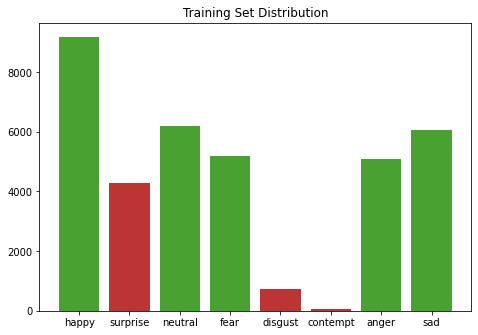

In [ ]:
plot_dataset(data_avfer[0], "Training Set Distribution")

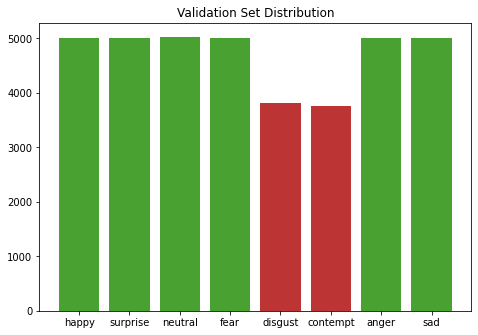

In [ ]:
plot_dataset(data_avfer[1], "Validation Set Distribution")

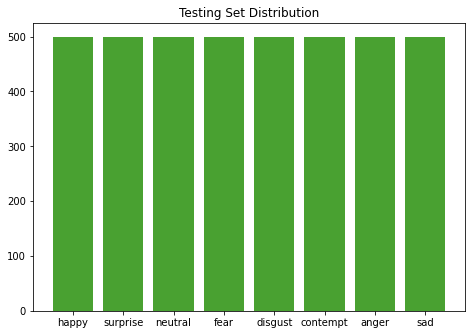

In [ ]:
plot_dataset(data_avfer[2], "Testing Set Distribution")

The situation is not so balanced. We need to use AffectNet on the validation and testing set for a subset of values. Meanwhile, the training set has to adopt augmentation values to improve the samples' number for the training phase. Validation and testing sets are not subjects of data augmentation.

## 3. Data Analysis


### 3.1 Data Analysis on AVFER
First of all, we need to check the amount of png and jpg on the training set. Actually, validation and testing set are in jpg image format due to the AffectNet splitting

In [ ]:
basedir = "/content/drive/MyDrive/Datasets/AVFER/*"
subsets = [dir for dir in glob.glob(basedir)]
df = pd.DataFrame(data={"class" : [], "jpg" : [], "png" : [], "set" : []})

for dir in subsets:
  classes = [cl for cl in glob.glob(dir + "/*")]
  for cl in classes:
    st = os.path.basename(dir)
    cls = os.path.basename(cl)
    png = iw.counter_file_extension(cl, "png")
    jpg = iw.counter_file_extension(cl, "jpg")
    df2 = pd.DataFrame(data={
          "class" : [cls], 
          "jpg" : [jpg], 
          "png" : [png], 
          "set" : [st]
    }) 
    df = pd.concat([df, df2], ignore_index = True, axis = 0)

df.head()

In [ ]:
def plt_set(typed, format):
  fig = plt.figure(figsize=(5.5,5.5))
  ax = fig.add_axes([0,0,1,1])
  cp = df[df['set'] == typed]
  ax.bar(cp['class'], 
       cp[format])
  plt.title(f'Amount of {format} images in the {typed} dataset')
  plt.ylabel('Number')
  plt.xlabel('Class')
  plt.show()  
plt_set('train', 'jpg')

In [ ]:
plt_set('train', 'png')

In [ ]:
plt_set('val', 'jpg') # AffectNet didn't have png

In [ ]:
plt_set('test', 'jpg') # AffectNet didn't have png

## 4. Loading and Balancing Datasets

### 4.1 AVFER Loading and Balancing
AVFER contains AffectNet in the validation and testing set and FER-2018 and CK+48 in the training set. We need to balance it remains only a small amount of samples in the val/test sets and put the rest in the training set. We need to balance every class in the testing and validation set before put the residual samples in the training folder.

In [ ]:
!mkdir /content/drive/MyDrive/Datasets/AVFER/tmp

In [ ]:
import sys
basedir = "/content/drive/MyDrive/Datasets/AVFER/"
types = ['val', 'test', 'train']
ref = [str(basedir  + types[i] + "/*") for i in range(len(types))]
total = 0
for el in ref:
  total += iw.counter_samples(el)

# Splitting ratio 100 :-> 80/20 (train/test) and 80 :-> 90/10 (train/val)
train_ratio = 80
val_ratio = 10
test_ratio = 20

# Splitting distribution
val_amount = int((((total * train_ratio) / 100) * 10 / 100))
test_amount = int((total * test_ratio)/ 100)
train_amount = int(total - (val_amount + test_amount))
print('Amount of samples per class for validation set:', val_amount) 
print('Amount of samples per class for testing set:', test_amount) 
print('Amount of samples per class for training set:', train_amount) 

# check augmentation of 3 
augm_train = train_amount * 3
print('Amount of augmented training set: ', augm_train)
print('Amount of samples for augmented training set divided by classes:', int(augm_train / 8))
print('Amount of samples for validation set divided by classes:', int(val_amount / 8))
print('Amount of samples for testing set divided by classes:', int(test_amount / 8))

# validation balancing 
val = ref[0]
min = sys.maxsize
countcl = iw.counter_samples_on_class(val)
for el in countcl.keys():
  if countcl[el] < min:
    min = countcl[el]

if min < (val_amount / 8):
  print('Error, the amount of samples for the validation set can\'t be reduce to minimum values')

classes = iw.list_classes(val)
residual = {}
for cl in classes:
  residual[cl] = countcl[cl] - ((val_amount / 8) + (test_amount / 8))

Amount of samples per class for validation set: 6275
Amount of samples per class for testing set: 15689
Amount of samples per class for training set: 56482
Amount of augmented training set:  169446
Amount of samples for augmented training set divided by classes: 21180
Amount of samples for validation set divided by classes: 784
Amount of samples for testing set divided by classes: 1961


In [ ]:
for cl in classes:
  os.mkdir(basedir + "tmp/" + cl + "/")

In [ ]:
import shutil

# check validation preconditions
print('Verify the correct amount for validation...')
err = False
for cl in classes:
  if countcl[cl] - residual[cl] - (test_amount / 8) < (val_amount / 8):
    print(f'Error, the residual amount put class {cl} to illegal value')
    err = True

if not err:
  print('Splitting possible.')

# splittig training and validation set according to the proportion previously calculated.
valdir = basedir + ref[0] + "/"
traindir = basedir + ref[2] + "/"
for cl in classes:
  c = 0
  for fl in glob.glob(valdir + cl + "/*"):
    if c < int(residual[cl]):
      c += 1
      shutil.copyfile(fl, os.path.join(traindir + cl, os.path.basename(fl)))
      os.remove(os.path.join(valdir + cl, os.path.basename(fl)))
    else:
      break

# done

Verify the correct amount for validation...
Splitting possible.


We put the residual samples of AffectNet from validation set to training set. The current amount of samples in the validation set is the sum of validation and testing validation. If we want to be sure that the splitting is doing correctly, we will execute the followings checking.

In [ ]:
# check testing splitting preconditions
residual_test = {}
print('Verify the correct amount for testing...')
for cl in classes:
  residual_test[cl] = countcl[cl] - residual[cl]
  if residual_test[cl] - (test_amount / 8) < (val_amount / 8):
    print(f'Error, the residual amount put class {cl} to illegal value')
    err = True

if not err:
  print('Splitting possible.')


print('Current status of the validation set:')
print('-'*60)
valdir = ref[0]
clcount = iw.counter_samples_on_class(valdir)
res = 0
for cl in classes:
  print(f'Total amount of {cl} samples in validation samples:', clcount[cl])
  res = clcount[cl] - int((test_amount / 8))
  print(f'Residual amount after last splitting {res}')
print('-'*60)
print(f'Final total amount of samples in the validation set:', res * 8)

Verify the correct amount for testing...
Splitting possible.
Current status of the validation set:
------------------------------------------------------------
Total amount of happy samples in validation samples: 5000
Residual amount after last splitting 3039
Total amount of surprise samples in validation samples: 5000
Residual amount after last splitting 3039
Total amount of neutral samples in validation samples: 5030
Residual amount after last splitting 3069
Total amount of fear samples in validation samples: 5000
Residual amount after last splitting 3039
Total amount of disgust samples in validation samples: 3803
Residual amount after last splitting 1842
Total amount of contempt samples in validation samples: 3750
Residual amount after last splitting 1789
Total amount of anger samples in validation samples: 5008
Residual amount after last splitting 3047
Total amount of sad samples in validation samples: 5000
Residual amount after last splitting 3039
---------------------------------

In [ ]:
valdir = basedir + "val" + "/"
testdir = basedir + "tmp" + "/"

for cl in classes:
  c = 0
  for fl in glob.glob(valdir + cl + "/*"):
    if c < int((test_amount / 8)):
      c += 1
      shutil.copyfile(fl, os.path.join(testdir + cl, os.path.basename(fl)))
      os.remove(os.path.join(valdir + cl, os.path.basename(fl)))
    else:
      break

print('Splitting completed')

Splitting completed


In [ ]:
for cl in classes:
  shutil.rmtree(basedir + "tmp/" + cl + "/")
os.rmdir(basedir + "tmp/")

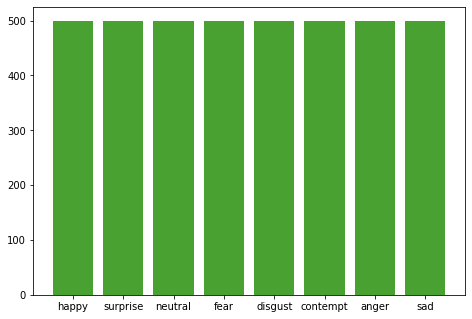

In [ ]:
testdir = "/content/drive/MyDrive/Datasets/AVFER/test"
plot_dataset(testdir + "/*")

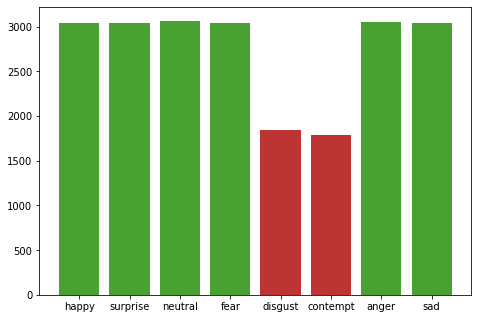

In [ ]:
valdir = "/content/drive/MyDrive/Datasets/AVFER/val"
plot_dataset(valdir + "/*")

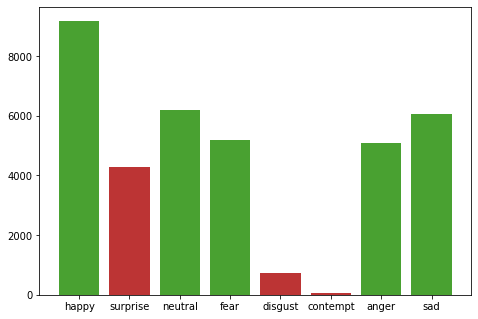

In [ ]:
traindir = "/content/drive/MyDrive/Datasets/AVFER/train"
plot_dataset(traindir + "/*")

In [ ]:
iw.counter_samples(traindir + "/*")

36855

To adjust that, we need to put more data in the training set taken from the validation set and try to underestimate the variation in the training phase. So, we can have more variety during the training phase and maintain high variance in well-formed images from AffectNet in the validation set and testing set to analyze the results.

In [ ]:
quantities = iw.counter_samples_on_class(valdir + "/*")
for cl in quantities.keys():
  print('Amount for class {} is {}'.format(cl, quantities[cl]))

Amount for class happy is 3039
Amount for class surprise is 3039
Amount for class neutral is 3069
Amount for class fear is 3039
Amount for class disgust is 1842
Amount for class contempt is 1789
Amount for class anger is 3047
Amount for class sad is 3039


In [ ]:
counters = iw.counter_samples_on_class(valdir + "/*")
for key in counters.keys():
  print(f'The current amount for the class {key} is {counters[key]}')
print('-'*40)
print('Balance it as well as the testing set...')
residual = 680
for cl in glob.glob(valdir + "/*"):
  total = counters[os.path.basename(cl)]
  count = total - residual
  print("{}: {} -> {} with residual of {}".format(os.path.basename(cl), total, count, total - count ))
  for fl in glob.glob(cl + "/*"):
    if count != 0:
      count = count - 1
      shutil.copyfile(fl, os.path.join(traindir,os.path.basename(cl), os.path.basename(fl)))
      os.remove(fl)
    else:
      break

print('Balanced completed.')
print('-'*40)

The current amount for the class happy is 3039
The current amount for the class surprise is 3039
The current amount for the class neutral is 3069
The current amount for the class fear is 3039
The current amount for the class disgust is 1842
The current amount for the class contempt is 1789
The current amount for the class anger is 3047
The current amount for the class sad is 3039
----------------------------------------
Balance it as well as the testing set...
happy: 3039 -> 2359 with residual of 680
surprise: 3039 -> 2359 with residual of 680
neutral: 3069 -> 2389 with residual of 680
fear: 3039 -> 2359 with residual of 680
disgust: 1842 -> 1162 with residual of 680
contempt: 1789 -> 1109 with residual of 680
anger: 3047 -> 2367 with residual of 680
sad: 3039 -> 2359 with residual of 680
Balanced completed.
----------------------------------------


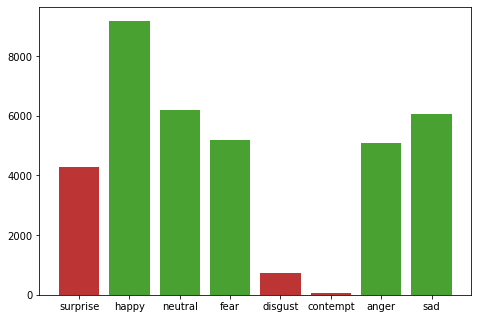

In [7]:
traindir = "/content/drive/MyDrive/Datasets/AVFER/train"
plot_dataset(traindir + "/*")

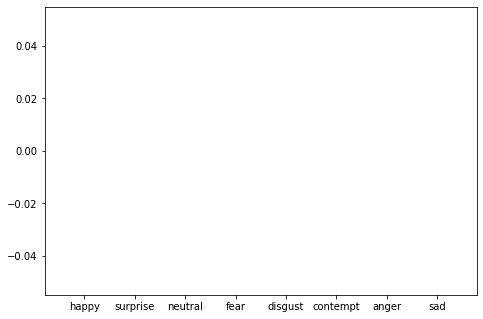

In [8]:
valdir = "/content/drive/MyDrive/Datasets/AVFER/val"
plot_dataset(valdir + "/*")

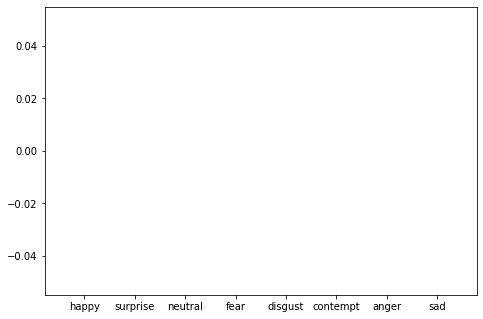

In [9]:
testdir = "/content/drive/MyDrive/Datasets/AVFER/test"
plot_dataset(testdir + "/*")

Unfortunately, the amount of data for the training set is unbalanced, so we need to preprocess data of this subfolder using data augmentation and possible integration with additional data, especially for the disgust and contempt classes.

## 5. Data Pre-processing

AVFER has some samples from CK+ as PNG and, generally, some images are in 1 channel (gray-scaling). We will avoid the artificial coloring and reduce side-effects of the fooling image.

In [20]:
path = "/content/drive/MyDrive/Datasets/AVFER/"

# checking the number of channels 

total = [0,0] # 0 for 1 channel, 1 for 3 channels
for path in glob.glob(path + "*"):
  for cl in glob.glob(path + "/*"):
    counter = [0,0] # 0 for 1 channel, 1 for 3 channels
    for fl in glob.glob(cl + "/*"):
      image = cv2.imread(fl)
      if(len(image.shape)<2):
        counter[0] += 1
        conv = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        if len(image.shape)==3:
          cv2.imwrite(fl, image)
      else:
        counter[1] += 1
    total = [total[i] + counter[i] for i in range(2)]

total



[0, 36852]

Actually, we have some elements in the gray-scale mode (FER-2013 and CK+48 samples). So we need to convert it to RGB (3 channels). In the gray-scale samples, each pixel has 1 byte (8 bit equals to a value from 0 to 255, corresponding of the brighness value of the image as described in the gray-scale representation). During the transformation, we need to convert this pixel in 3 channels corresponding to 3 bytes equals to the red, green and blue values. In this convertion, each channel has the same value of the brighness to mantain the gray tone of colored pixel with no value perturbation.

In [ ]:
path = "/content/drive/MyDrive/Datasets/AVFER/"
total = [0,0] # 0 for 1 channel, 1 for 3 channels

for path in glob.glob(path + "*"):
  for cl in glob.glob(path + "/*"):
    counter = [0,0] # 0 for 1 channel, 1 for 3 channels
    for fl in glob.glob(cl + "/*"):
      image = cv2.imread(fl)
      if(len(image.shape)<2):
        counter[0] += 1
      else:
        counter[1] += 1
    total = [total[i] + counter[i] for i in range(2)]

total 

[0, 62758]

In [ ]:
image = Image.open('/content/drive/MyDrive/Datasets/FER-2013/train/anger/Training_10118481.jpg')
image.mode # L is gray-scale

'L'

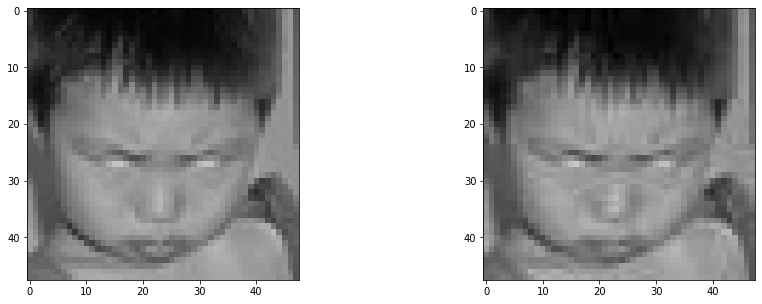

In [15]:
# test image in L mode
test = '/content/drive/MyDrive/Datasets/FER-2013/train/anger/Training_10118481.jpg'
pic = imageio.imread(test)
image = Image.open(test)

# convert to RGB
image = image.convert('RGB')
im_rgb = cv2.cvtColor(pic, cv2.COLOR_BGR2RGB)
# temporal saving 
tmp = '/content/test.jpg'
image.save(tmp)
pic2 = imageio.imread(tmp)

# remove temporal image
os.remove(tmp)

# plot the result and compare with L and RGB version
fig, ax = plt.subplots(nrows = 1, ncols=2, figsize=(15,5)) 
ax1, ax2 = ax
ax1.imshow(im_rgb[ :, :])
ax2.imshow(pic2[:,:,:])

In [16]:
pic3 = imageio.imread("/content/drive/MyDrive/Datasets/AffectNet/train_class/anger/Copia di image0000006.jpg")
pic3[0] # Array of pixel values for a colored image

Array([[94, 68, 53],
       [91, 65, 50],
       [93, 67, 52],
       ...,
       [37, 43, 55],
       [36, 42, 54],
       [36, 42, 54]], dtype=uint8)

In [19]:
im_rgb[0] # Array of pixels values for a gray-scaled image 

array([[ 50,  50,  50],
       [ 32,  32,  32],
       [ 15,  15,  15],
       [ 11,  11,  11],
       [ 12,  12,  12],
       [ 10,  10,  10],
       [ 10,  10,  10],
       [  8,   8,   8],
       [ 15,  15,  15],
       [ 10,  10,  10],
       [  7,   7,   7],
       [  7,   7,   7],
       [  6,   6,   6],
       [  5,   5,   5],
       [  5,   5,   5],
       [  6,   6,   6],
       [  8,   8,   8],
       [  4,   4,   4],
       [  6,   6,   6],
       [ 10,  10,  10],
       [  3,   3,   3],
       [  6,   6,   6],
       [ 13,  13,  13],
       [  4,   4,   4],
       [  8,   8,   8],
       [ 11,  11,  11],
       [ 15,  15,  15],
       [ 10,  10,  10],
       [  6,   6,   6],
       [  8,   8,   8],
       [  7,   7,   7],
       [  8,   8,   8],
       [  6,   6,   6],
       [ 19,  19,  19],
       [ 19,  19,  19],
       [ 22,  22,  22],
       [ 20,  20,  20],
       [ 22,  22,  22],
       [ 47,  47,  47],
       [ 61,  61,  61],
       [ 42,  42,  42],
       [ 55,  55

In [17]:
# Array of pixels values for 3 channels adaptation of the gray-scale image
pic2[0]

Array([[ 57,  57,  57],
       [ 31,  31,  31],
       [ 11,  11,  11],
       [ 11,  11,  11],
       [ 14,  14,  14],
       [  8,   8,   8],
       [  6,   6,   6],
       [ 10,  10,  10],
       [ 17,  17,  17],
       [ 10,  10,  10],
       [  0,   0,   0],
       [  3,   3,   3],
       [ 12,  12,  12],
       [  5,   5,   5],
       [  0,   0,   0],
       [  8,   8,   8],
       [  6,   6,   6],
       [  8,   8,   8],
       [  0,   0,   0],
       [ 12,  12,  12],
       [  8,   8,   8],
       [  0,   0,   0],
       [ 15,  15,  15],
       [  0,   0,   0],
       [ 11,  11,  11],
       [ 12,  12,  12],
       [ 12,  12,  12],
       [ 10,  10,  10],
       [  7,   7,   7],
       [  6,   6,   6],
       [  7,   7,   7],
       [  9,   9,   9],
       [ 11,  11,  11],
       [ 14,  14,  14],
       [ 20,  20,  20],
       [ 23,  23,  23],
       [ 20,  20,  20],
       [ 23,  23,  23],
       [ 42,  42,  42],
       [ 64,  64,  64],
       [ 43,  43,  43],
       [ 53,  53

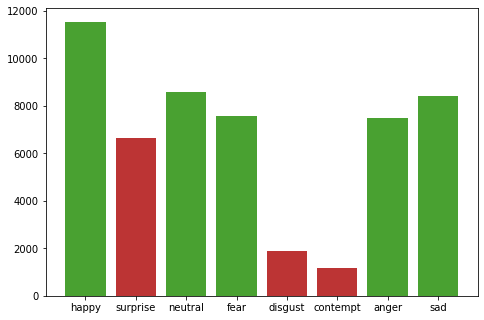

In [ ]:
traindir = "/content/drive/MyDrive/Datasets/AVFER/train"
plot_dataset(traindir + "/*")

In [ ]:
ref = "/content/drive/MyDrive/Datasets/AVFER/train"

for cl in glob.glob(ref + "/*"):
  print("Convert from class {}".format(cl))
  for fl in glob.glob(cl + "/*"):
    if fl[len(fl)-4:len(fl)] == '.png':
      os.rename(fl, str(fl[0:len(fl)-4]) + ".jpg")

Convert from class /content/drive/MyDrive/Datasets/AVFER/train/happy
Convert from class /content/drive/MyDrive/Datasets/AVFER/train/surprise
Convert from class /content/drive/MyDrive/Datasets/AVFER/train/neutral
Convert from class /content/drive/MyDrive/Datasets/AVFER/train/fear
Convert from class /content/drive/MyDrive/Datasets/AVFER/train/disgust
Convert from class /content/drive/MyDrive/Datasets/AVFER/train/contempt
Convert from class /content/drive/MyDrive/Datasets/AVFER/train/anger
Convert from class /content/drive/MyDrive/Datasets/AVFER/train/sad


In [ ]:
ref = "/content/drive/MyDrive/Datasets/AVFER/train"

counter = 0

for cl in glob.glob(ref + "/*"):
  print("Counting png on class {}".format(cl))
  for fl in glob.glob(cl + "/*"):
    if fl[len(fl)-4:len(fl)] == '.png':
      counter += 1

print('Remaining png samples: {}'.format(counter))

Counting png on class /content/drive/MyDrive/Datasets/AVFER/train/happy
Counting png on class /content/drive/MyDrive/Datasets/AVFER/train/surprise
Counting png on class /content/drive/MyDrive/Datasets/AVFER/train/neutral
Counting png on class /content/drive/MyDrive/Datasets/AVFER/train/fear
Counting png on class /content/drive/MyDrive/Datasets/AVFER/train/disgust
Counting png on class /content/drive/MyDrive/Datasets/AVFER/train/contempt
Counting png on class /content/drive/MyDrive/Datasets/AVFER/train/anger
Counting png on class /content/drive/MyDrive/Datasets/AVFER/train/sad
Remaining png samples: 0


Renaming the source folders for augmentation, only train is considered.

In [ ]:
# renaming files pre-augmentation

testdir = "/content/drive/MyDrive/Datasets/AVFER/train"
for cl in glob.glob(testdir + "/*"):
  counter = 0
  for img in glob.glob(cl + "/*"):
      os.rename(img, cl + "/" + os.path.basename(cl) + "-" + str(counter) + "-file" + img[len(img) - 4 : len(img)])
      counter += 1

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

def generator(path, 
              format_img, 
              dest_path,
              starting_counter=0, 
              num_augment=1, 
              zoom_range=0.6, 
              brightness_range=(0.2,0.8),
              width_shift_range=0.2,
              height_shift_range=0.2,
              rotation_range=10
              ):
   gen = ImageDataGenerator(
            featurewise_center=True,
            featurewise_std_normalization=True,
            rotation_range=rotation_range,
            width_shift_range=width_shift_range,
            height_shift_range=height_shift_range,
            brightness_range=brightness_range,
            zoom_range=zoom_range,
            horizontal_flip=True
            )
   print(f'Data Augmentation parameters:\nZoom Range: {zoom_range}\nBrighness Range: {brightness_range}\nShift: ({width_shift_range},{height_shift_range})\nRotation Degrees: {rotation_range}')
   if iw.navigate_path(dest_path) == 0:
      os.mkdir(dest_path)
   num_el = iw.navigate_path(dest_path)
   c = starting_counter
   print('Starting generation...')
   for file in glob.glob(path + "/*." + format_img):
      img = cv2.imread(file)
      # convert to numpy array
      # expand dimension to one sample
      samples = np.expand_dims(img, 0)
      iterator = gen.flow(samples, batch_size=1)
      for i in range(0, num_augment):
          batch = iterator.next()
          image = batch[0].astype('uint8')
          cv2.imwrite(dest_path + "augmented_on_" + str(num_el) + "_" + str(c) + "."+ format_img, image)
          c += 1
   print(f'Data Augmentation for the {path} is done!')

In [ ]:
augm_class = []
categories_data = iw.counter_samples_on_class("/content/drive/MyDrive/Datasets/AVFER/train/*")
for class_ in classes:
  if categories_data[class_] < 5000:
    augm_class.append(class_)

augm_class

['disgust', 'contempt']

In [ ]:
class_ = "/anger"
generator("/content/drive/MyDrive/Datasets/Test/train" + class_, "jpg", "/content/drive/MyDrive/Datasets/Test/train" + class_ + "/", 0, num_augment=2)

Data Augmentation parameters:
Zoom Range: 0.6
Brighness Range: (0.2, 0.8)
Shift: (0.2,0.2)
Rotation Degrees: 10
Starting generation...


/usr/local/lib/python3.7/dist-packages/keras_preprocessing/image/image_data_generator.py:720: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/usr/local/lib/python3.7/dist-packages/keras_preprocessing/image/image_data_generator.py:728: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


Data Augmentation for the /content/drive/MyDrive/Datasets/Test/train/anger is done!


## 6. Training Transformer

In [ ]:
!pip install timm

In [ ]:
import timm, torch, os
from torchvision import datasets, models, transforms

input_size = (224,224)
batch_size = 60

data_dir= "/content/drive/MyDrive/Datasets/ViT-VFER/"

In [ ]:
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(input_size),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
    ]),
    'val': transforms.Compose([
        transforms.Resize(input_size),
        transforms.ToTensor(),
        transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
    ]),
}
# Detect if we have a GPU available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


print("Initializing Datasets and Dataloaders...")

# Create training and validation datasets
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x]) for x in ['train', 'val']}

# Create training and validation dataloaders
dataloaders_dict = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=batch_size, shuffle=True, num_workers=8,pin_memory=True) for x in ['train', 'val']}

In [ ]:
from __future__ import print_function
from __future__ import division
from torch.optim import lr_scheduler
import torch.nn as nn
import torch.optim as optim
import numpy as np
import torchvision
import time
import copy
print("PyTorch Version: ",torch.__version__)
print("Torchvision Version: ",torchvision.__version__)

In [ ]:
NUM_CLASSES = 8
model = timm.create_model('vit_base_patch16_224', pretrained=True)

In [ ]:
model.eval()

In [ ]:
model.head = nn.Linear(768, NUM_CLASSES)
model.eval()

In [ ]:
import pickle, sys


def save_history(history, filename):
  if os.path.isfile(filename):
    os.remove(filename)
  file_handler = open(filename + ".pkl", "wb")
  pickle.dump(history, file_handler)
  file_handler.close()


def load_history(filename):
  file_handler = open(filename + ".pkl", "rb")
  output = pickle.load(file_handler)
  file_handler.close()
  return output


def train_model(model, dataloaders, criterion, optimizer,lr_scheduler, num_epochs=25, is_inception=False, 
                is_loaded = False, load_state_ws=None, history_file_acc="history_accuracy",
                history_file_loss="history_loss", n_partial=0, model_folder=""):
    
    history = {'val' : [], 'train' : []}
    loss_history = {'val' : [], 'train' : []}

    if is_loaded and load_state_ws != None:
      # load the model
      state_dict = torch.load(load_state_ws)
      model.load_state_dict(state_dict)
      model.eval()
      print('Model loaded correctly')
      # history = load_history(history_file_acc)
      # loss_history = load_history(history_file_loss)
      # print('History loaded')

    
    print('Starting Training')
    print('-' * 12)

    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    for epoch in range(num_epochs):
        epoch_since = time.time()
        print(f'Epoch {epoch + 1}/{num_epochs}')
        print('-' * 12)
        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            total = len(dataloaders[phase])
            current = 0
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            dl = dataloaders[phase]
            totalIm=0
            # Iterate over data.
            for inputs, labels in dl:
                totalIm+=len(inputs)
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    # Get model outputs and calculate loss
                      outputs = model(inputs)
                      loss = criterion(outputs, labels)

                      _, preds = torch.max(outputs, 1)

                    # backward + optimize only if in training phase
                      if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
                epoch_loss = running_loss / totalIm
                epoch_acc = running_corrects.double() / totalIm
                # status update
                current += 1

                sys.stdout.write("\r" + f"{epoch + 1}/{num_epochs} - {phase} step : " + str(current * batch_size) + "/" +  str(total * batch_size) + " - " + 
                                 "{}_accuracy : ".format(phase) + "{:4f}".format(epoch_acc) + " - {}_loss : ".format(phase) + "{:4f}".format(epoch_loss))
                sys.stdout.flush()

                
              
            epoch_loss = running_loss / totalIm
            epoch_acc = running_corrects.double() / totalIm
            print() # avoid result cleaning 
            if phase == 'train':
              history['train'].append(epoch_acc)
              loss_history['train'].append(epoch_loss)

            # deep copy the model only in case the accusary is better in evaluation (local optima)
            local_optima = False
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
                local_optima = True
            if phase == 'val':
                history['val'].append(epoch_acc)
                loss_history['val'].append(epoch_loss)

            # Increases the internal counter
        if lr_scheduler:            
            lr_scheduler.step()            
        lr = optimizer.param_groups[0]['lr']
        interval_epoch = time.time() - epoch_since 
        print('\nEpoch {} complete in. {:.0f}m {:.0f}s {} with a learning rate of {}'.format(epoch + 1, interval_epoch // 60, interval_epoch % 60, "with best local accuracy" if local_optima else "",lr))
        save_history(loss_history, model_folder + os.path.basename(model_folder) + "_" + history_file_loss)
        
        torch.save(model.state_dict(), model_folder + "epoch_{}_{}".format(epoch + 1, os.path.basename(model_folder[:len(model_folder) - 1])))
        print("-" * 12)

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val accuracy: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, history['train'], history['val']

In [ ]:
# Detect if we have a GPU available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
# Send the model to GPU
model = model.to(device)
feature_extract=False

# Gather the parameters to be optimized/updated in this run. If we are
#  finetuning we will be updating all parameters. However, if we are
#  doing feature extract method, we will only update the parameters
#  that we have just initialized, i.e. the parameters with requires_grad
#  is True.
params_to_update = model.parameters()
print("Params to learn:")

for name,param in model.named_parameters():
    if param.requires_grad == True:
          print("\t",name)

# stochasic gradient descent
lr_in = 0.001
momentum_in = 0.9
optimizer_ft = optim.SGD(params_to_update, lr=lr_in, momentum=momentum_in)

In [ ]:
import warnings
warnings.filterwarnings('ignore')

# Setup the loss fxn
criterion = nn.CrossEntropyLoss()
num_epochs = 10

# model general info
name_model = "vfer_small_50"
base_dir = "/content/drive/MyDrive/Models/"

def mkdir_model(base_dir, name_model, counter):
  try:
    d = "{}/{}".format(base_dir,name_model)
    os.mkdir(d)
  except FileExistsError:
    counter += 1
    mkdir_model(base_dir, str(name_model) + "_" + str(counter), counter)

mkdir_model(base_dir, name_model, 0)

# model files for saving history and model data
model_folder = base_dir + name_model + "/"
model_file = model_folder + name_model + ".pth"
train_history = model_folder + name_model + "_" + "history_train"
val_history = model_folder + name_model + "_" + "history_val"


# Learning Rate schedule: decays the learning rate by a factor of `gamma` 
# every `step_size` epochs
scheduler = lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

# Train and evaluate
model, train_hist, val_hist = train_model(model, dataloaders_dict, criterion, optimizer_ft,scheduler, num_epochs=num_epochs, 
                                          is_inception=False, is_loaded=True, model_folder=model_folder, 
                                          load_state_ws="/content/drive/MyDrive/Models/vfer_small_50_on_5/epoch_5_vfer_small_50")


#Saving the updated model for the inference phase
torch.save(model.state_dict(), model_file)

# Save histories data
save_history(train_hist, train_history)
save_history(val_hist, val_history)

## 7. Evaluation

In this section, we will evaluate the performances of our model based on the accuracy and loss values on the training and validation set with some histograms for the progress analysis during the training phase. 

(0.0, 1.0)

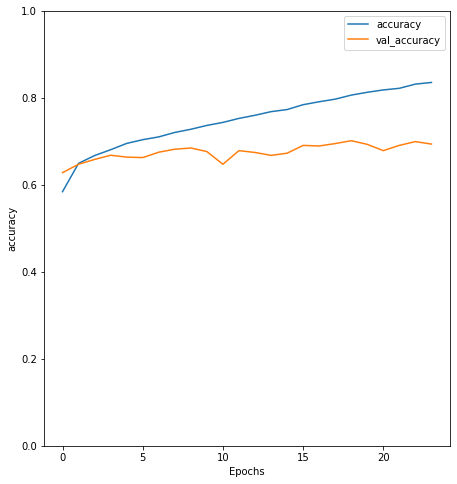

In [ ]:
# plot and data management functions

def plot_graphs(train, val, metric):
    plt.plot(train)
    plt.plot(val, '')
    plt.xlabel("Epochs")
    plt.ylabel(metric)
    plt.legend([metric, 'val_'+metric])

def tensor_to_list(tensor_list):
  l = []
  for el in tensor_list:
    l.append(el.item())
  return l

# model info for the evaluation
name_model = "vfer_small_5"
base_dir = "/content/drive/MyDrive/Models/"
model_folder = base_dir + name_model + "/"

# accuracy plot
_train = load_history(model_folder + name_model + "_history_train")
_val = load_history(model_folder + name_model + "_history_val")
l_train = tensor_to_list(_train)
l_val = tensor_to_list(_val)

plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plot_graphs(l_train, l_val, 'accuracy')
plt.ylim(0, 1)

(0.0, 0.0253303)

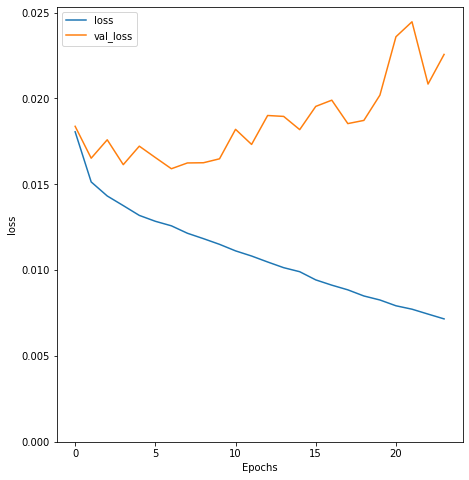

In [ ]:
# loss plot
_loss = load_history(base_dir + name_model + "/" + name_model + "_history_loss")
plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plot_graphs(_loss['train'], _loss['val'], 'loss')
plt.ylim(0, None)